
#### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

#### Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?
#### В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.


In [69]:
#импорт библиотек
import pandas as pd
import datetime
import numpy as np
from scipy import stats as st
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import levene
import pingouin as pg
import scipy.stats as ss
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
from operator import attrgetter
import matplotlib.colors as mcolors
from datetime import datetime

import requests 
from urllib.parse import urlencode

%matplotlib inline
from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')


In [70]:
warnings.simplefilter(action='ignore', category=Warning)

#### 1.Считывание и исследование данных

На этот раз считаем данные с  яндекс диска, как это указано в ссылке LMS

In [71]:
#https://disk.yandex.ru/d/SOkIsD5A8xlI7Q
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href']

In [72]:
problem2 = pd.read_csv(download_url, sep=';') 

In [73]:
problem2.head(10)


,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b
7,8,0,b
8,9,0,b
9,10,0,a


.tail(10)

Исследуем датасет на чистоту данных

In [74]:
problem2.shape[0]

404770

In [75]:
problem2.isna().sum() # Пропусков нет

user_id      0
revenue      0
testgroup    0
dtype: int64

In [76]:
problem2.user_id.nunique() == problem2.shape[0] # все юзеры уникальные
   

True

In [77]:
problem2.revenue.describe() # Проверим, какие значения у выручки ( на наличие отрицательных)

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

Отрицательных значений нет

##### В данном задании уже задан принцип сплитования, группы A(контрольные) и B(тестовые) известны. Для будущих вычислений создадим датафреймы 

In [78]:
control = problem2.query('testgroup == "a"') #Контрольная группа


In [79]:
test = problem2.query('testgroup == "b"') #Тестовая группа


In [80]:
print(f'Выборка контрольной группы равна', control.shape[0])
print(f'Выборка тестовой группы равна', test.shape[0])

Выборка контрольной группы равна 202103
Выборка тестовой группы равна 202667


Группы примерно равны, что нужно учесть при дальнейшем выборе стат. теста

Для бизнеса одна из важнейших метрик- это ARPU. рассмотрим сколько их, оценим выборки для корректной проверки стат. тестов

In [81]:
#Бизнес особо волнует метрика ARPU, ARPPU и, cоотв-но платежеспособные пользователи. рассмотрим сколько их
buying_control= problem2.query("testgroup == 'a' and revenue > 0")
buying_test = problem2.query("testgroup == 'b' and revenue > 0")
print(f'Выборка контрольной группы равна', buying_control.shape[0])
print(f'Выборка тестовой группы равна', buying_test.shape[0])
#Ответ соответствует условиям задания

Выборка контрольной группы равна 1928
Выборка тестовой группы равна 1805


В общем тоже различия небольшие

In [82]:

ARPU_control = control.revenue.mean()
ARPU_test = test.revenue.mean()
delta_ARPU = ((ARPU_test/ARPU_control * 100) - 100)
print(f'Разница в метрике ARPU между группами составляет', delta_ARPU.round(0),'%') 
#Проверим разницу ARPU в 5% согласно условиям, видим, что все сходится

Разница в метрике ARPU между группами составляет 5.0 %


#### 2. Анализ распределеений и стат.тесты

Посмотрим на стат показатели платящих пользователей

In [83]:
buying_control.revenue.describe() 


count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [84]:
 buying_test.revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Среднее значение выручки в контрольной и тестовой группах покупающих пользователей примерно одного порядка- 2663 и 3003 , но медианное при этом отличается почти в 10 раз,311 и 3022, у  контрольной и тестовой группах, соответственно.

Посмотрим графики распределения выручки для всех пользователей.

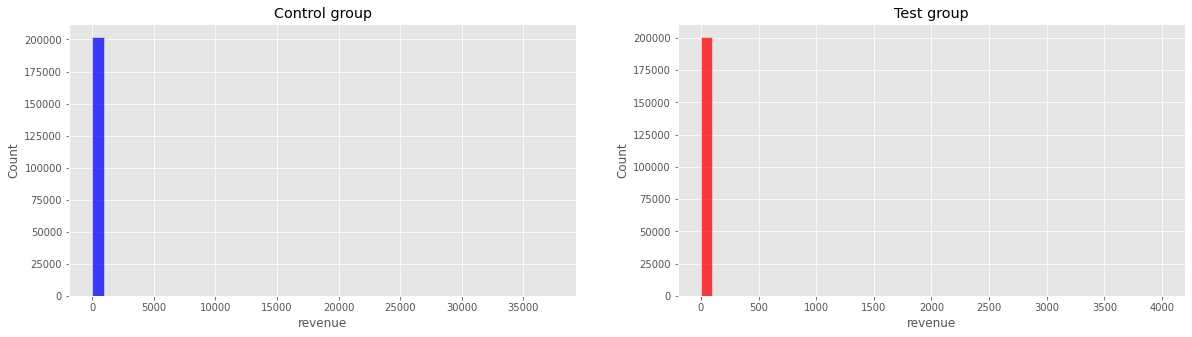

In [85]:
# размечаем пространство для вывода графиков
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 5)
)

# гистограмма распределения группа А
sns.histplot(data=control,
            x='revenue', bins=40, color='blue',
            ax=ax1)
ax1.set_title('Control group')

# гистограмма распределения группа B
sns.histplot(data=test,
            x='revenue', bins=40, color='red',
            ax=ax2)
ax2.set_title('Test group');


Слишком много пользователей с revenue=0, поэтому о распределении выручки согласно визуальным данным мало что можно сказать.

Посмотрим графики распределения выручки для платящих пользователей.

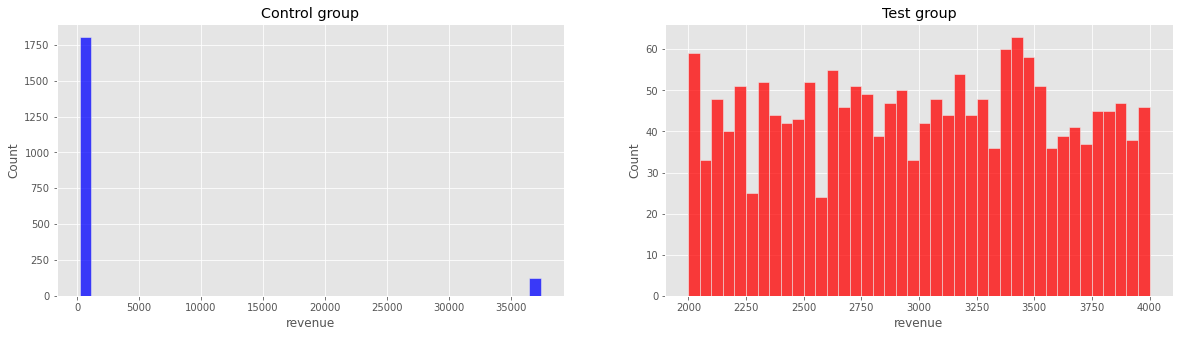

In [86]:
# размечаем пространство для вывода графиков
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 5)
)

# гистограмма распределения группа А
sns.histplot(data=buying_control,
            x='revenue', bins=40, color='blue',
            ax=ax1)
ax1.set_title('Control group')

# гистограмма распределения группа B
sns.histplot(data=buying_test,
            x='revenue', bins=40, color='red',
            ax=ax2)
ax2.set_title('Test group');


Картина наглядная. Видим, как в контрольной группе неравномерно распределены пользователи, есть много пользователей с маленьким чеком при этом имеется выброс в виде тех, кто совершал покупки выше 35000

Построим также боксплоты

Text(0.5, 1.0, 'Test group')

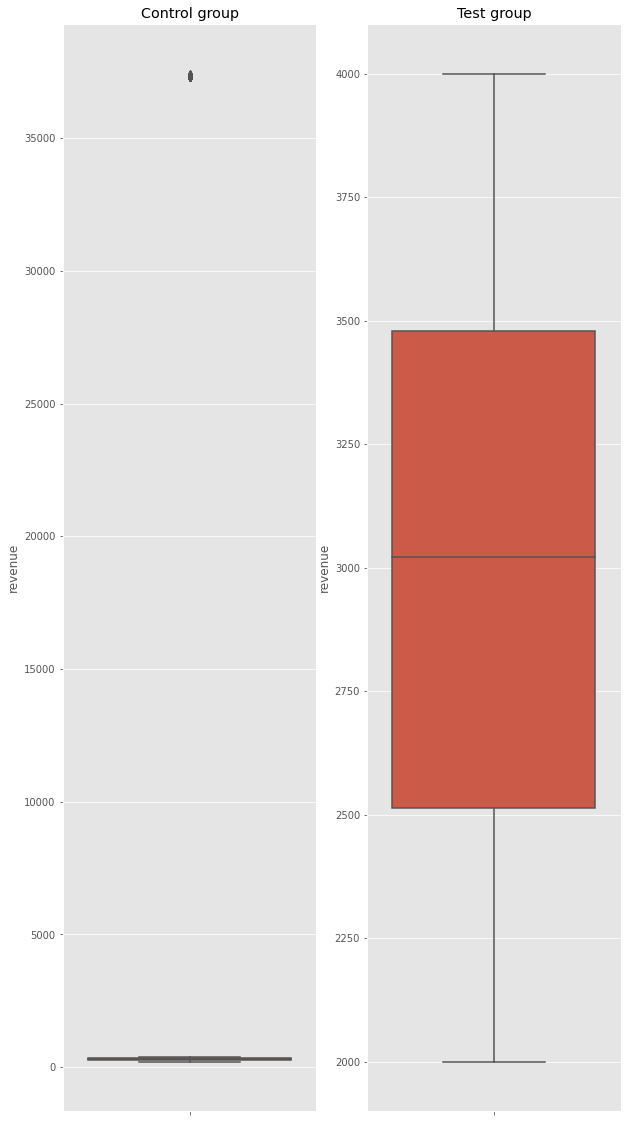

In [87]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(10, 20)
)

# гистограмма распределения группа А
sns.boxplot(data=buying_control,
            y='revenue',
            ax=ax1)
ax1.set_title('Control group')

# гистограмма распределения группа B
sns.boxplot(data=buying_test,
            y='revenue',
            ax=ax2)
ax2.set_title('Test group')

Здесь тоже в тестовой группе видно выброс, это точка в верху графика, также наглядно видна разница медианных величин. \

In [88]:
print(f'Количество пользователей с большим чеком в контрольной группе составляет ', buying_control.query('revenue > 35000').shape[0])

Количество пользователей с большим чеком в контрольной группе составляет  123


In [89]:
123/buying_control.shape[0]*100

6.379668049792531

Относительно всех покупок это 6%

### Вернемся к аналитике метрики ARPU. 

Для выбора  статистического теста нам нужно проверить сведения о гомогенности дисперсий и нормальнсти распределения

In [90]:
pg.normality(data=problem2, dv="revenue", group="testgroup", method="normaltest")

,W,pval,normal
b,326622.395409,0.0,False
a,585152.731273,0.0,False


Распределение не является нормальным. Проверим другим стат тестом

In [91]:
st.shapiro(test.revenue)

ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)

In [92]:
st.shapiro(control.revenue)

ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)

Распределение все еще является ненормальным

###### Проведем Тест Левена на гомогенность дисперсий

In [93]:

levene(control.revenue, test.revenue) #для всех пользователей

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

pvalue=0.53,дисперсии не различаются

Итак, при выборе стат теста учтем следующие соображения:

1. Выборки групп, как мы могли увидеть в EDA довольно большая, около 20 тыс пользователей
2. Нужно сравнить распределение средних значений
3. данные имеют одинаковую (гомогенную дисперсию (p-value>0.05)
5. Распределение ненормальное

с учетом этих пунктов в качестве применения теста годится классический Т-тест, Да, распределение выборок ненормальное, однако в не очень малых выборках (наш кейс) t-критерий относительно устойчив к ненормальному распределению исходных данных.

####  Сформулируем гипотезы для ARPU 
#### Нулевая гипотеза H0:  средние значения revenue (метрика ARPU) между группами не различаются
#### Альтернативная гипотеза H1:  средние значения revenue (метрика ARPU)между группами различаются

In [94]:
pg.ttest(control.revenue, test.revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.623488,240991.130782,two-sided,0.532965,"[-5.54, 2.87]",0.001962,0.004,0.095694


p-val>0.05, следовательно стат. значимых различий между метриками средней выручки в тестовой и контрольной группе нет. Принимаем нулевую гипотезу


### Анализ метрики ARPPU



In [95]:
ARPPU_control = buying_control.revenue.mean()
ARPPU_test = buying_test.revenue.mean()
delta_ARPPU = ((ARPPU_test/ARPPU_control * 100) - 100)
print(f'Разница в метрике ARPPU между группами составляет', delta_ARPPU.round(0),'%') 


Разница в метрике ARPPU между группами составляет 13.0 %


In [96]:
ARPPU_control

2663.9984439834025

In [97]:
ARPPU_test

3003.6581717451522

Проверим на нормальность,

In [98]:
st.shapiro(buying_control.revenue) 

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

st.shapiro(buying_test.revenue)

P value<0.05, cледовательно распределение в обеих группах платящих юзеров ненормальное.

Проверим распределения выручки платящих пользователей на гомогенность дисперсий

In [99]:
levene(buying_control.revenue, buying_test.revenue) 

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

P value<0.05, значит дисперсии в двух группах неоднородны, 


1. Нужно сравнить распределение средних значений
2. данные имеют различную (негомогенную дисперсию (p-value<0.05). Тут отличие от групп всех пользователей.
3. Распределение ненормальное
4. Большой размер выборок, меньше чем в случае со всеми юзерами, но все равно достаточно много

Дисперсия между двумя группами неодинакова , что не дает нам для анализа метрики ARPPU использовать классический Т-тест, однако  можно вместо этого использовать t-критерий Уэлча , который является непараметрическим эквивалентом t-теста д.

#### Сформулируем гипотезы для ARPPU 
#### Нулевая гипотеза H0:  средние значения revenue (метрика ARPPU) между контрольной и тестовой группами среди платящих пользователей не различаются (стат. значимо)
#### Альтернативная гипотеза H1:  средние значения revenue (метрика ARPPU)между группами  платящих пользователей стат. значимо различаются

Проведем сам Тест Уэлча

In [100]:
ttest_ind(buying_control.revenue, buying_test.revenue, equal_var=False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

P Value имеет большое значение больше 0.05, что позволяет нам принять нулевую гипотезу H0- Средние значения выручки среди только платящих пользователей не различаются стат. значимо 


По умолчанию задание тестовое и данные мы можем принимать как абсолютную истину, однако мое внимание не оставляет факт, что в контрольной группе имеется несколько премиальных игроков, совершающих сверх большие покупки, в силу недостаточности информации мы не можем сказать о их природе и том, корректно ли провели сплитование, но считать это выбросами нет оснований. В качестве эксперимента можно провести тест, как изменится разница в средних значениях выручки между группами юзеров, если отсечь этот сегмент,  это вооружит бизнес доп. информацией

In [101]:
buying_control_short = buying_control.query("revenue < 35000") # отсечем

In [102]:
st.shapiro(buying_control_short.revenue) 

ShapiroResult(statistic=0.9546283483505249, pvalue=3.004845972000649e-23)

In [103]:
levene(buying_control_short.revenue, buying_test.revenue) 

LeveneResult(statistic=4256.810323520863, pvalue=0.0)

тесты на нормальность и гомогенность дисперсий показали, что распределение ненормально и дисперсии неоднородны.как и в предыдущем случае можно провести стат тест по Т-критерию Уэлча, гипотезы, соответственно оставляем такие же как для ARPPU выше

In [104]:
ttest_ind(buying_control_short.revenue, buying_test.revenue, equal_var=False) # проводим стат. тест

Ttest_indResult(statistic=-199.39722533995328, pvalue=0.0)

Здесь уже наблюдаем, что нулевая гипотеза отклоняется и значения выручки игроков  в тестовой группе и контрольной группе без премиальных игроков 
статистически различаются

Очень интересная картина, с одной стороны численные значения средней выручки в тестовой группе больше, однако по результатам AB тестов метрик средних, статистически значимо они не изменились. Остается проверить, в какой группе игроки платят охотнее, поэтому разберем влияние последней метрики, чтобы сполна использовать все возможности  информации датасета

### Анализ метрики CR ( conversion rate)

Узнаем, изменилась ли конверсия платящих пользователей. сходу сформулируем гипотезы

#### Нулевая гипотеза (H0): в тестовой и контрольной группах конверсии пользователей в покупку не отличаются
#### Альтернативная гипотеза (H1): в тестовой и контрольной группах конверсии пользователей в покупку отличаются статистически значимо

Посчитаем метрику конверсии

In [118]:
СR_a=buying_control.shape[0]/control.shape[0]
СR_b=buying_test.shape[0]/test.shape[0]
СR_a


0.009539690157988749

In [119]:
delta_CR=(СR_a-СR_b)*100/СR_a
delta_CR

6.640203150326494

In [120]:
print(f'Разница в метрике CR между группами составляет', round(delta_CR,3),'%')

Разница в метрике CR между группами составляет 6.64 %


Численно между метриками не очень большая разница(в пользу контрольной группу),казалось бы, но проверим ее с точки зрения статистических критериев . Поскольку факт оплаты- это не численная переменная , а категориальная,то уместно испольхзование критерия хи квадрат,

In [121]:
problem2Cr= problem2 #сделаем таблицу для задания
problem2Cr

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [122]:
problem2Cr['Did_buy']=problem2Cr.revenue.apply ( lambda x: ' Yes ' if x > 0 else ' no')
problem2Cr

,user_id,revenue,testgroup,Did_buy
0,1,0,b,no
1,2,0,a,no
2,3,0,a,no
3,4,0,b,no
4,5,0,b,no
...,...,...,...,...
404765,404766,0,a,no
404766,404767,0,b,no
404767,404768,231,a,Yes
404768,404769,0,a,no


In [123]:
Problem2cross=pd.crosstab(problem2Cr.testgroup,problem2Cr.Did_buy)
Problem2cross # получим таблицу сопряженности

Did_buy,Yes,no
testgroup,,
a,1928,200175
b,1805,200862


In [124]:
chi2_contingency(Problem2cross) # проводим тест


(4.374729521260405,
 0.03647561892312613,
 1,
 array([[  1863.89924896, 200239.10075104],
        [  1869.10075104, 200797.89924896]]))

P value=0.036, что говорит нам о том, что разница метрики Сonversion Rate на почти  7% является статистически значимой, нулевая гипотеза не принимается, принимаем H1

### Выводы

Мы сравнили две группы по параметрам средней выручки,соответственно проведя AB тесты по сравнению метрик ARPU и APRRU. Результаты неп показали статичтически значимых отличий, однако при EDA было отмечено о необычном  распределении игроков в контрольной группе, а именно 6% клиентов, делающих огромный чек. У нас нет оснований считать значения выручки этих пользователей выбросами, поэтому также проведен AB тест между группами, но в контрольной исключили VIP игроков, здесь уже в метрике ARPPU имеем стат. значимое отличие. Однако данный эксперимент не повлияетна наш итоговый выбор группы, поскольку нет сведений о природе таких данных у игроков и о том, корректно ли мы провели сплитование.
Кроме того, дополнительно рассмотрели метрику конверсии в покупку у пользователей двух групп, и CR в контрольной группе оказался больше на 6,6%  и эта разница оказалась стат. значимой, то есть несмотря на графики, в тестовой группе с внедрением акций стали хуже покупать.


##### Поэтому лучше сделать выбор в пользу контрольной группы, а также , если бизнесу все же принципиальны показатели выручки рекомендуется провести дополнительные акции для удержания Вип пользователей( если считать, что в целом контрольная группа сформирована корректно) поскольку они имеют существенное влияние на выручку в этой группе, вероятно это обойдется дешевле, чем внедрять какие-то акционные предложения глобально. 